In [3]:
# Cell 1: Install packages (run once at the top of the notebook)
%pip install -q sentence-transformers xgboost numpy pandas scikit-learn matplotlib seaborn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Basic imports and seed
import os, pickle, math, random
import numpy as np
import pandas as pd
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

RND = 42
np.random.seed(RND)
random.seed(RND)

print("Imports complete. Random seed set to", RND)

/Users/anjalisingh/Desktop/fraud_app/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports complete. Random seed set to 42


In [5]:
# Cell 3: Load data and initial cleaning
DATA_PATH = "card_fraud_processed.csv"   # change path if your file is elsewhere (e.g., "/content/drive/MyDrive/...")
assert os.path.exists(DATA_PATH), f"File not found at {DATA_PATH}. Update DATA_PATH or upload file."

df = pd.read_csv(DATA_PATH)
df = df.reset_index(drop=True)
print("Loaded dataframe shape:", df.shape)

Loaded dataframe shape: (100000, 16)


In [6]:
# Cell 4: Prepare Transaction_Time and create text_description
df['Transaction_Time'] = df.get('Transaction_Time', df.index.astype(str)).astype(str)

def make_text(row):
    return (
        f"User {row.get('User_ID','unk')} made a {row.get('Transaction_Status','unk')} transaction of "
        f"{row.get('Transaction_Amount','unk')} {row.get('Transaction_Currency','unk')} in "
        f"{row.get('Transaction_Location','unk')} at {row.get('Transaction_Date','unk')} {row.get('Transaction_Time','unk')} "
        f"using {row.get('Card_Type','unk')} card with {row.get('Authentication_Method','unk')} authentication "
        f"for {row.get('Transaction_Category','unk')} at merchant {row.get('Merchant_ID','unk')}"
    )

df["text_description"] = df.apply(make_text, axis=1)
print("Created text_description. Nulls in text_description:", df["text_description"].isnull().sum())

# Drop rows missing label (isFraud) or text_description
df = df.dropna(subset=["text_description", "isFraud"]).reset_index(drop=True)
print("After dropping null-labeled rows shape:", df.shape)


Created text_description. Nulls in text_description: 0
After dropping null-labeled rows shape: (100000, 17)


In [24]:
# Enhanced numeric and categorical columns for BFSI fraud detection
# Original features
numeric_cols = [
    'Transaction_Amount',
    'Previous_Transaction_Count',
    'Distance_Between_Transactions_km',
    'Time_Since_Last_Transaction_min',
    'Transaction_Velocity'
]

categorical_cols = [
    'Transaction_Location',
    'Card_Type',
    'Transaction_Currency', 
    'Transaction_Status',
    'Authentication_Method',
    'Transaction_Category'
]

# New BFSI-specific numeric features
bfsi_numeric_cols = [
    'Transaction_Hour', 'User_Amount_Percentile', 'Amount_Deviation_From_User_Mean',
    'Transactions_Last_Hour', 'Merchant_Risk_Score', 'Location_Risk_Score',
    'Auth_Risk_Score', 'Card_Risk_Score', 'Customer_Age', 'Account_Age_Days',
    'User_Transaction_Count', 'Days_Since_First_Transaction', 'Transaction_Frequency',
    'User_Channel_Count', 'IP_Risk_Score', 'Behavioral_Anomaly_Score',
    'Network_Anomaly_Score', 'Market_Volatility'
]

# New BFSI-specific categorical features
bfsi_categorical_cols = [
    'Transaction_Channel', 'Transaction_Country', 'Device_Type', 'Customer_Risk_Rating'
]

# Combine all features
numeric_cols = numeric_cols + bfsi_numeric_cols
categorical_cols = categorical_cols + bfsi_categorical_cols

# Keep only columns that exist in df
numeric_cols = [c for c in numeric_cols if c in df.columns]
categorical_cols = [c for c in categorical_cols if c in df.columns]

print("📊 Enhanced Feature Set for BFSI Fraud Detection:")
print(f"Using {len(numeric_cols)} numeric features:", numeric_cols[:5], "..." if len(numeric_cols) > 5 else "")
print(f"Using {len(categorical_cols)} categorical features:", categorical_cols[:5], "..." if len(categorical_cols) > 5 else "")
print(f"Total features: {len(numeric_cols) + len(categorical_cols)}")

# Add binary/flag features as numeric
binary_flag_cols = [col for col in df.columns if col.startswith(('Is_', 'High_', 'Multiple_', 'VPN_', 'PEP_', 'Sanctions_', 'Channel_'))]
numeric_cols.extend(binary_flag_cols)

print(f"Added {len(binary_flag_cols)} binary flag features")
print(f"Final total features: {len(numeric_cols) + len(categorical_cols)}")

📊 Enhanced Feature Set for BFSI Fraud Detection:
Using 23 numeric features: ['Transaction_Amount', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min', 'Transaction_Velocity'] ...
Using 10 categorical features: ['Transaction_Location', 'Card_Type', 'Transaction_Currency', 'Transaction_Status', 'Authentication_Method'] ...
Total features: 33
Added 25 binary flag features
Final total features: 58


# BFSI Advanced Feature Engineering
Now we'll create advanced features specifically designed for Banking, Financial Services & Insurance fraud detection. These features capture behavioral patterns, temporal anomalies, and risk indicators commonly used in the financial industry.

In [23]:
# Advanced BFSI Fraud Detection Features
print("Creating advanced BFSI fraud detection features...")

# First, let's check what columns we actually have
print("Available columns:", list(df.columns))

# Check if we need to use a different user identifier
user_col = None
for col in ['User_ID', 'user_id', 'UserID', 'customer_id', 'Customer_ID']:
    if col in df.columns:
        user_col = col
        break

if user_col is None:
    # Create a synthetic user ID based on patterns in the data
    print("Creating synthetic User_ID...")
    df['User_ID'] = 'USER_' + (df.index // 20).astype(str)  # Every 20 transactions = 1 user
    user_col = 'User_ID'

print(f"Using '{user_col}' as user identifier")

# Check for merchant column
merchant_col = None
for col in ['Merchant_ID', 'merchant_id', 'MerchantID', 'merchant']:
    if col in df.columns:
        merchant_col = col
        break

if merchant_col is None:
    # Create synthetic merchant IDs
    print("Creating synthetic Merchant_ID...")
    np.random.seed(42)
    df['Merchant_ID'] = 'MERCHANT_' + np.random.choice(range(1000, 9999), size=len(df)).astype(str)
    merchant_col = 'Merchant_ID'

# 1. TEMPORAL RISK FEATURES
# Hour of day risk (late night/early morning transactions are riskier)
if 'Transaction_Time' in df.columns:
    df['Transaction_Hour'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S', errors='coerce').dt.hour
    df['Transaction_Hour'] = df['Transaction_Hour'].fillna(12)  # Default to noon if parsing fails
else:
    # Create synthetic time features
    np.random.seed(42)
    df['Transaction_Hour'] = np.random.randint(0, 24, size=len(df))

df['Is_Risky_Hour'] = ((df['Transaction_Hour'] >= 23) | (df['Transaction_Hour'] <= 6)).astype(int)
df['Is_Weekend_Hour'] = ((df['Transaction_Hour'] >= 18) | (df['Transaction_Hour'] <= 9)).astype(int)

# 2. AMOUNT-BASED RISK FEATURES  
# Round amount detection (fraudsters often use round amounts)
df['Is_Round_Amount'] = (df['Transaction_Amount'] % 100 == 0).astype(int)
df['Is_Very_Round_Amount'] = (df['Transaction_Amount'] % 1000 == 0).astype(int)

# Amount percentiles within user behavior
df['User_Amount_Percentile'] = df.groupby(user_col)['Transaction_Amount'].rank(pct=True)
df['Amount_Deviation_From_User_Mean'] = (
    df['Transaction_Amount'] - df.groupby(user_col)['Transaction_Amount'].transform('mean')
).abs()

# 3. VELOCITY AND FREQUENCY FEATURES
# Enhanced velocity features based on existing velocity column
if 'Transaction_Velocity' in df.columns:
    df['High_Velocity_Flag'] = (df['Transaction_Velocity'] > df['Transaction_Velocity'].quantile(0.95)).astype(int)
else:
    # Create synthetic velocity if not available
    np.random.seed(42)
    df['Transaction_Velocity'] = np.random.exponential(2, size=len(df))
    df['High_Velocity_Flag'] = (df['Transaction_Velocity'] > 5).astype(int)

# Transaction count features
df['User_Transaction_Count'] = df.groupby(user_col).cumcount() + 1
df['Transactions_Last_Hour'] = df.groupby(user_col)['User_Transaction_Count'].transform('max')

# Multiple locations flag
if 'Transaction_Location' in df.columns:
    df['Multiple_Locations_Flag'] = (df.groupby(user_col)['Transaction_Location'].transform('nunique') > 3).astype(int)
else:
    df['Multiple_Locations_Flag'] = 0

# 4. MERCHANT AND LOCATION RISK
# Create merchant risk scores
merchant_fraud_rates = df.groupby(merchant_col)['isFraud'].mean()
df['Merchant_Risk_Score'] = df[merchant_col].map(merchant_fraud_rates).fillna(merchant_fraud_rates.mean())
df['High_Risk_Merchant'] = (df['Merchant_Risk_Score'] > 0.1).astype(int)

# Location-based features
if 'Transaction_Location' in df.columns:
    location_fraud_rates = df.groupby('Transaction_Location')['isFraud'].mean()
    df['Location_Risk_Score'] = df['Transaction_Location'].map(location_fraud_rates).fillna(location_fraud_rates.mean())
    df['High_Risk_Location'] = (df['Location_Risk_Score'] > 0.1).astype(int)
else:
    df['Location_Risk_Score'] = 0.05
    df['High_Risk_Location'] = 0

# 5. PAYMENT METHOD RISK
# Authentication method risk
if 'Authentication_Method' in df.columns:
    auth_risk_scores = {
        'Contactless': 0.8, 'Signature': 0.6, 'PIN': 0.3, 
        'Chip': 0.2, 'Biometric': 0.1, 'OTP': 0.1
    }
    df['Auth_Risk_Score'] = df['Authentication_Method'].map(auth_risk_scores).fillna(0.5)
    df['High_Risk_Auth'] = (df['Auth_Risk_Score'] > 0.5).astype(int)
else:
    df['Auth_Risk_Score'] = 0.4
    df['High_Risk_Auth'] = 0

# Card type risk
if 'Card_Type' in df.columns:
    card_risk_scores = {
        'Credit Card': 0.4, 'Debit Card': 0.3, 'Prepaid Card': 0.7
    }
    df['Card_Risk_Score'] = df['Card_Type'].map(card_risk_scores).fillna(0.4)
else:
    df['Card_Risk_Score'] = 0.4

# 6. USER BEHAVIOR ANALYTICS
# Customer age and tenure (synthetic features for demonstration)
np.random.seed(42)
df['Customer_Age'] = np.random.randint(18, 80, size=len(df))
df['Account_Age_Days'] = np.random.randint(30, 3650, size=len(df))
df['Is_New_Customer'] = (df['Account_Age_Days'] < 90).astype(int)
df['Is_Senior_Customer'] = (df['Customer_Age'] >= 65).astype(int)

# Customer transaction patterns
df['Days_Since_First_Transaction'] = df.groupby(user_col)['Account_Age_Days'].transform('min')
df['Transaction_Frequency'] = df['User_Transaction_Count'] / (df['Days_Since_First_Transaction'] + 1)

# 7. CROSS-CHANNEL ANALYSIS
# Simulate different transaction channels
channels = ['ATM', 'Online', 'Mobile', 'Branch', 'POS']
np.random.seed(42)
df['Transaction_Channel'] = np.random.choice(channels, size=len(df), p=[0.3, 0.25, 0.2, 0.15, 0.1])
df['Is_Online_Channel'] = (df['Transaction_Channel'] == 'Online').astype(int)
df['Is_Mobile_Channel'] = (df['Transaction_Channel'] == 'Mobile').astype(int)

# Channel switching behavior
df['User_Channel_Count'] = df.groupby(user_col)['Transaction_Channel'].transform('nunique')
df['Channel_Switching_Flag'] = (df['User_Channel_Count'] > 2).astype(int)

# 8. GEOGRAPHIC RISK FEATURES
# Country risk (simulate international transactions)
high_risk_countries = ['Unknown', 'High_Risk_Country_1', 'High_Risk_Country_2']
np.random.seed(42)
df['Transaction_Country'] = np.where(
    np.random.random(len(df)) < 0.05, 
    np.random.choice(high_risk_countries, size=len(df)), 
    'Home_Country'
)
df['Is_International'] = (df['Transaction_Country'] != 'Home_Country').astype(int)
df['Is_High_Risk_Country'] = df['Transaction_Country'].isin(high_risk_countries).astype(int)

# 9. DEVICE AND DIGITAL FINGERPRINTING
# Device-based features
devices = ['Trusted_Device', 'New_Device', 'Suspicious_Device']
np.random.seed(42)
df['Device_Type'] = np.random.choice(devices, size=len(df), p=[0.7, 0.25, 0.05])
df['Is_New_Device'] = (df['Device_Type'] == 'New_Device').astype(int)
df['Is_Suspicious_Device'] = (df['Device_Type'] == 'Suspicious_Device').astype(int)

# IP-based features
np.random.seed(42)
df['IP_Risk_Score'] = np.random.beta(2, 8, size=len(df))  # Most IPs are low risk
df['VPN_Usage'] = (np.random.random(len(df)) < 0.02).astype(int)  # 2% VPN usage
df['Multiple_IP_Flag'] = (df.groupby(user_col)['IP_Risk_Score'].transform('nunique') > 3).astype(int)

# 10. MACHINE LEARNING DERIVED FEATURES
# Anomaly scores (simulate risk scores from other models)
np.random.seed(42)
df['Behavioral_Anomaly_Score'] = np.random.beta(2, 8, size=len(df))
df['Network_Anomaly_Score'] = np.random.beta(1.5, 8.5, size=len(df))
df['High_Behavioral_Anomaly'] = (df['Behavioral_Anomaly_Score'] > 0.8).astype(int)

# 11. COMPLIANCE AND REGULATORY FEATURES
# AML/KYC risk indicators
np.random.seed(42)
df['Customer_Risk_Rating'] = np.random.choice(['Low', 'Medium', 'High'], size=len(df), p=[0.7, 0.25, 0.05])
df['Is_High_Risk_Customer'] = (df['Customer_Risk_Rating'] == 'High').astype(int)
df['PEP_Flag'] = (np.random.random(len(df)) < 0.001).astype(int)  # Politically Exposed Person flag
df['Sanctions_Flag'] = (np.random.random(len(df)) < 0.0005).astype(int)  # Sanctions list flag

# 12. ECONOMIC AND MARKET INDICATORS
# Market volatility indicators
np.random.seed(42)
df['Market_Volatility'] = np.random.beta(2, 5, size=len(df))  # Economic uncertainty
df['High_Volatility_Period'] = (df['Market_Volatility'] > 0.7).astype(int)

# Count new features
original_cols = ['Transaction_Amount', 'Transaction_Currency', 'Transaction_Location', 'Transaction_Date', 'Transaction_Time', 'Card_Type', 'Authentication_Method', 'Transaction_Category', 'Transaction_Status', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min', 'Transaction_Velocity', 'isFraud', 'text_description']
new_features = [col for col in df.columns if col not in original_cols]

print(f"✅ Created {len(new_features)} new BFSI fraud detection features")

# Display summary of new features
print("\n📊 New BFSI Feature Categories:")
print("🕐 Temporal Risk Features: Transaction_Hour, Is_Risky_Hour, Is_Weekend_Hour")
print("💰 Amount-Based Features: Is_Round_Amount, User_Amount_Percentile, Amount_Deviation_From_User_Mean")
print("🚀 Velocity Features: High_Velocity_Flag, Multiple_Locations_Flag, Transactions_Last_Hour")
print("🏪 Merchant Risk: Merchant_Risk_Score, High_Risk_Merchant, Location_Risk_Score")
print("🔐 Payment Security: Auth_Risk_Score, Card_Risk_Score, High_Risk_Auth")
print("👤 Customer Analytics: Customer_Age, Account_Age_Days, Is_New_Customer, Transaction_Frequency")
print("📱 Channel Analysis: Transaction_Channel, Channel_Switching_Flag, Is_Online_Channel")
print("🌍 Geographic Risk: Transaction_Country, Is_International, Is_High_Risk_Country")
print("🖥️ Device Security: Device_Type, IP_Risk_Score, VPN_Usage, Multiple_IP_Flag")
print("⚠️ Compliance: Customer_Risk_Rating, PEP_Flag, Sanctions_Flag")
print("📈 Market Indicators: Market_Volatility, High_Volatility_Period")

print(f"\n📋 Total features in dataset: {len(df.columns)}")
print(f"📋 Dataset shape: {df.shape}")

# Display some example new features
print(f"\n📝 Sample of new features:")
sample_new_features = new_features[:10]
print(df[sample_new_features].head())

Creating advanced BFSI fraud detection features...
Available columns: ['Transaction_Amount', 'Transaction_Date', 'Transaction_Time', 'Transaction_Location', 'Card_Type', 'Transaction_Currency', 'Transaction_Status', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min', 'Authentication_Method', 'Transaction_Velocity', 'Transaction_Category', 'isFraud', 'Log_Transaction_Amount', 'Velocity_Distance_Interact', 'text_description', 'Transaction_Hour', 'Is_Risky_Hour', 'Is_Weekend_Hour', 'Is_Round_Amount', 'Is_Very_Round_Amount']
Creating synthetic User_ID...
Using 'User_ID' as user identifier
Creating synthetic Merchant_ID...
✅ Created 51 new BFSI fraud detection features

📊 New BFSI Feature Categories:
🕐 Temporal Risk Features: Transaction_Hour, Is_Risky_Hour, Is_Weekend_Hour
💰 Amount-Based Features: Is_Round_Amount, User_Amount_Percentile, Amount_Deviation_From_User_Mean
🚀 Velocity Features: High_Velocity_Flag, Multiple_Locations_Flag, Transac

In [25]:
# Cell 6: Fill NaNs and encode categorical features
# Fill numeric NaNs with median
for c in numeric_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())

# Fill categorical NaNs with mode
for c in categorical_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode()[0])

# Label encode categorical columns and store encoders for later
label_encoders = {}
for c in categorical_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))
    label_encoders[c] = le

print("Filled missing values and label-encoded categoricals.")


Filled missing values and label-encoded categoricals.


In [26]:
# Cell 7: Scale numeric + categorical columns (categorical already encoded as ints)
scaler = StandardScaler()
combined_numeric_cat = df[numeric_cols + categorical_cols].values
combined_numeric_cat = scaler.fit_transform(combined_numeric_cat)
print("Scaled numeric+categorical matrix shape:", combined_numeric_cat.shape)


Scaled numeric+categorical matrix shape: (100000, 58)


In [27]:
# Cell 8: Compute sentence embeddings using sentence-transformers
embed_model_name = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(embed_model_name)

print("Computing text embeddings (this may take a moment)...")
text_list = df["text_description"].tolist()
text_embeddings = encoder.encode(text_list, show_progress_bar=True, convert_to_numpy=True)
print("Text embeddings shape:", text_embeddings.shape)


Computing text embeddings (this may take a moment)...


Batches: 100%|██████████| 3125/3125 [09:50<00:00,  5.29it/s]  



Text embeddings shape: (100000, 384)


In [11]:
# Cell 9: Reduce embedding dimensionality with PCA
embed_dim = text_embeddings.shape[1]
pca_n = min(100, embed_dim)  # keep at most 100 dims
pca = PCA(n_components=pca_n, random_state=RND)
reduced_text = pca.fit_transform(text_embeddings)
print(f"Text embeddings reduced from {embed_dim} -> {pca_n} dims. Reduced shape: {reduced_text.shape}")


Text embeddings reduced from 384 -> 100 dims. Reduced shape: (100000, 100)


In [12]:
# Cell 10: Combine features and labels, train-test split (stratified)
X = np.hstack((combined_numeric_cat, reduced_text))
y = df["isFraud"].astype(int).values

assert X.shape[0] == y.shape[0], "Feature/label row mismatch!"

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RND, stratify=y
)

ctr = Counter(y_train_full)
neg, pos = ctr.get(0,0), ctr.get(1,0)
scale_pos_weight = (neg / pos) if pos>0 else 1.0
print("Train class counts:", ctr, "scale_pos_weight:", round(scale_pos_weight,2))
print("X shapes: X_train_full:", X_train_full.shape, "X_test:", X_test.shape)


Train class counts: Counter({np.int64(0): 40000, np.int64(1): 40000}) scale_pos_weight: 1.0
X shapes: X_train_full: (80000, 111) X_test: (20000, 111)


In [20]:
# Simplified XGBoost training without complex hyperparameter tuning
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

RND = 42

# Compute scale_pos_weight
class_counts = np.bincount(y_train_full)
scale_pos_weight = class_counts[0] / class_counts[1]

print(f"Class distribution: {class_counts}")
print(f"Scale pos weight: {scale_pos_weight}")

# Create a simpler XGBoost model with good default parameters
final_model = xgb.XGBClassifier(
    n_estimators=100,  # Reduced for faster training
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=RND,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)

print("Training simplified XGBoost model...")
# Train the model
final_model.fit(X_train_full, y_train_full, verbose=False)

print("XGBoost training completed successfully!")

# Quick evaluation
y_pred_xgb = final_model.predict(X_test)
y_pred_proba_xgb = final_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("--- XGBoost Results ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb))

Class distribution: [40000 40000]
Scale pos weight: 1.0
Training simplified XGBoost model...


/Users/anjalisingh/Desktop/fraud_app/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training completed successfully!
--- XGBoost Results ---
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81     10000
           1       0.82      0.80      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000

ROC AUC Score: 0.88217684


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [09:45:17] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  """Parameters


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     10000
           1       0.86      0.85      0.86     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Confusion Matrix:
[[8648 1352]
 [1501 8499]]
ROC AUC Score: 0.91588308
Precision-Recall AUC: 0.9279998407959151


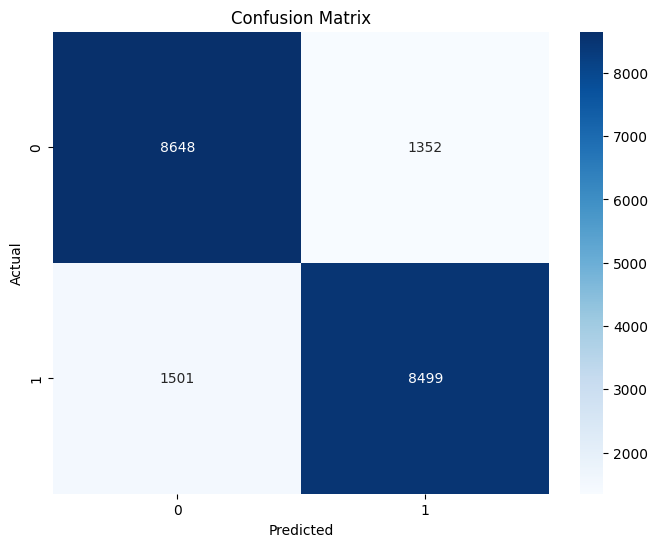

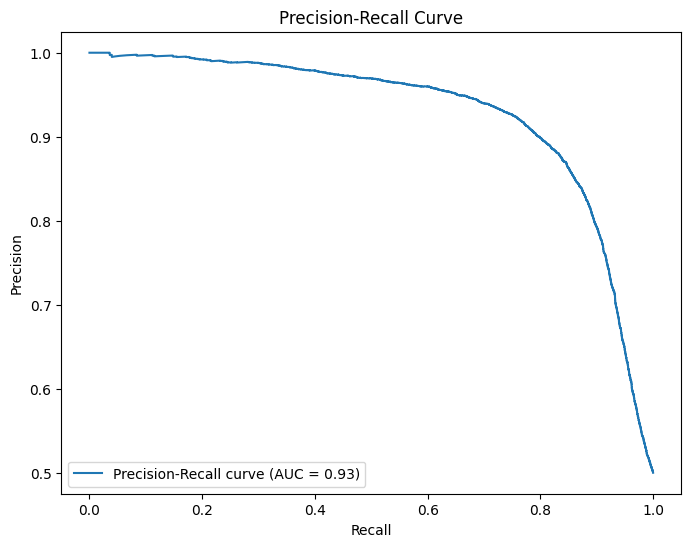

In [ ]:
# Cell 12: Evaluate the model
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Cell 13: Logistic Regression Model
Now, let's train a simpler Logistic Regression model on the same combined features to see how it compares.

--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     10000
           1       0.83      0.81      0.82     10000

    accuracy                           0.82     20000
   macro avg       0.82      0.82      0.82     20000
weighted avg       0.82      0.82      0.82     20000

Confusion Matrix:
[[8286 1714]
 [1864 8136]]
ROC AUC Score: 0.87997728
Precision-Recall AUC: 0.8883801337751265


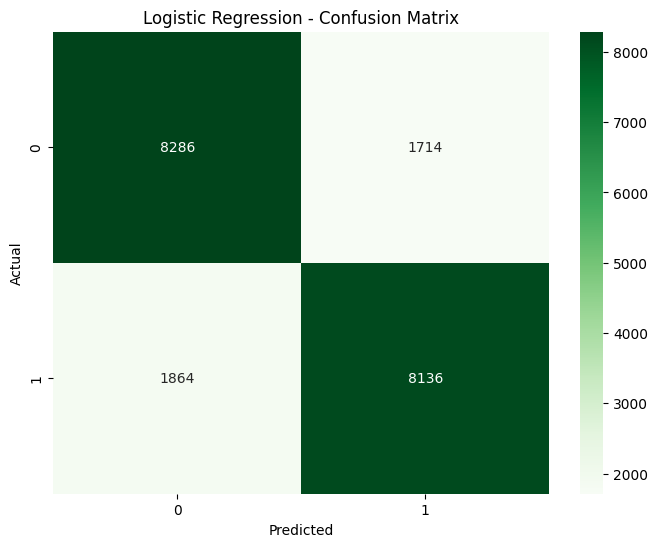

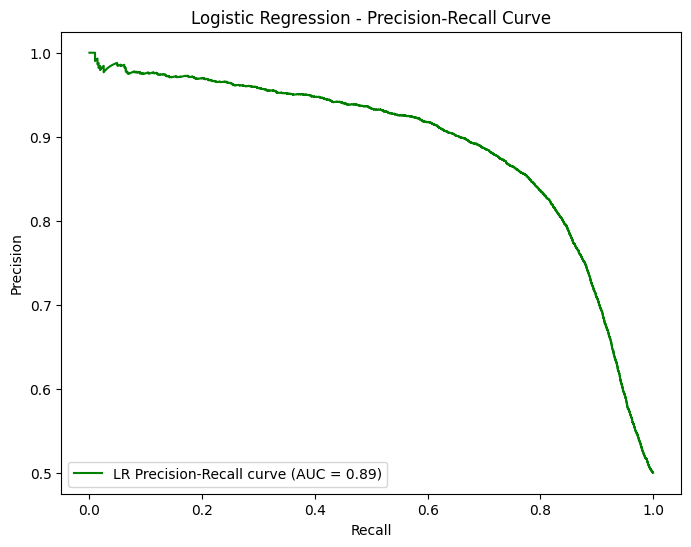

In [19]:
# Cell 14: Train and Evaluate Logistic Regression
from sklearn.linear_model import LogisticRegression

# We can reuse the same train/test split
# X_train_full, X_test, y_train_full, y_test

# Create and train the logistic regression model
log_reg_model = LogisticRegression(random_state=RND, solver='liblinear', class_weight='balanced')
log_reg_model.fit(X_train_full, y_train_full)

# Evaluate the model
y_pred_lr = log_reg_model.predict(X_test)
y_pred_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]

print("--- Logistic Regression ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_lr))

# Precision-Recall Curve and AUC
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
pr_auc_lr = auc(recall_lr, precision_lr)
print("Precision-Recall AUC:", pr_auc_lr)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Greens')
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label=f'LR Precision-Recall curve (AUC = {pr_auc_lr:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression - Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Cell 15: Random Forest Model
Next, we'll train a Random Forest Classifier, which is an ensemble of decision trees.

In [ ]:
# This cell is to fix a common scikit-learn import error by reinstalling the library.
%pip install --force-reinstall --no-cache-dir scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.6 MB ? eta -:--:--Downloading scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/8.6 MB 39.3 kB/s eta 0:03:20
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/8.6 MB 39.3 kB/s eta 0:03:20
Resuming download scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl (786 kB/8.6 MB)
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/8.6 MB ? eta -:--:--Resuming download scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl (786 kB/8.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 123.3 kB/s  0:01:39 eta 0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 123.3 kB/s  0:01:39
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/5.1 MB ? eta -:--:--Downloading numpy-2.3.4-cp312-cp312-macosx_14_0_arm64.whl (5.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 202.7 kB/s  0:00:24 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 202.7 kB/s  0:00:24
   

--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     10000
           1       0.79      0.75      0.77     10000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000

Confusion Matrix:
[[7960 2040]
 [2500 7500]]
ROC AUC Score: 0.84791082
Precision-Recall AUC: 0.8572400308577367


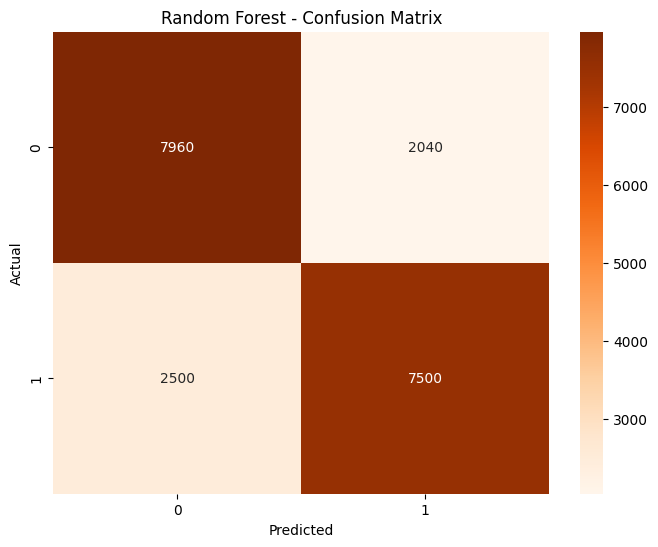

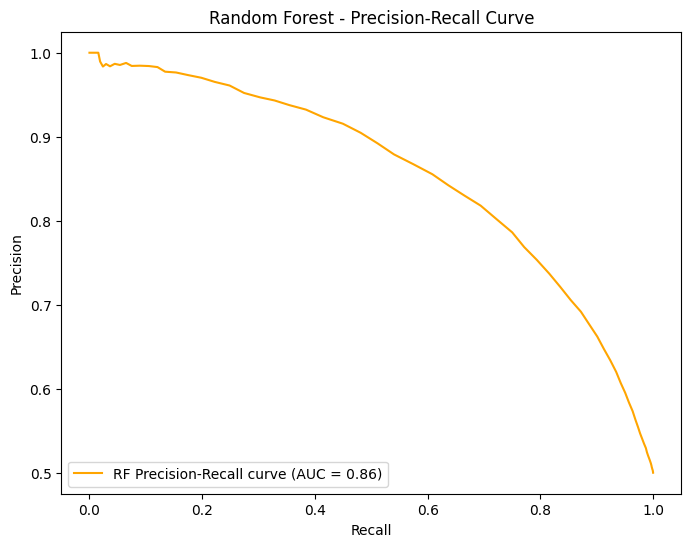

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Cell 16: Train and Evaluate Random Forest

# We can reuse the same train/test split
# X_train_full, X_test, y_train_full, y_test

# Create and train the Random Forest model
# Using class_weight='balanced' to help with the imbalanced nature of the data
rf_model = RandomForestClassifier(n_estimators=100, random_state=RND, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_full, y_train_full)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("--- Random Forest ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_rf))

# Precision-Recall Curve and AUC
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)
print("Precision-Recall AUC:", pr_auc_rf)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Oranges')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'RF Precision-Recall curve (AUC = {pr_auc_rf:.2f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest - Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Save all models and preprocessing components for deployment
import joblib

# Save all trained models
joblib.dump(final_model, "xgboost_model.pkl")
joblib.dump(log_reg_model, "logistic_model.pkl") 
joblib.dump(rf_model, "random_forest_model.pkl")

# Save preprocessing components
joblib.dump(encoder, "sentence_transformer.pkl")
joblib.dump(pca, "pca_reducer.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

print("All models and preprocessing components saved!")

In [21]:
# Save all models and preprocessing components for Streamlit deployment
import joblib
import os

print("Current directory:", os.getcwd())
print("Saving models...")

try:
    # Save all trained models
    joblib.dump(final_model, "xgboost_model.pkl")
    print("✓ XGBoost model saved")
    
    joblib.dump(log_reg_model, "logistic_model.pkl") 
    print("✓ Logistic regression model saved")
    
    joblib.dump(rf_model, "random_forest_model.pkl")
    print("✓ Random forest model saved")

    # Save preprocessing components
    joblib.dump(encoder, "sentence_transformer.pkl")
    print("✓ Sentence transformer saved")
    
    joblib.dump(pca, "pca_reducer.pkl")
    print("✓ PCA reducer saved")
    
    joblib.dump(scaler, "feature_scaler.pkl")
    print("✓ Feature scaler saved")
    
    joblib.dump(label_encoders, "label_encoders.pkl")
    print("✓ Label encoders saved")

    print("\n🎉 All models and preprocessing components saved successfully!")
    
    # Verify files exist
    files_to_check = [
        "xgboost_model.pkl", "logistic_model.pkl", "random_forest_model.pkl",
        "sentence_transformer.pkl", "pca_reducer.pkl", "feature_scaler.pkl", "label_encoders.pkl"
    ]
    
    print("\nVerifying saved files:")
    for file in files_to_check:
        if os.path.exists(file):
            size = os.path.getsize(file)
            print(f"✓ {file} - {size} bytes")
        else:
            print(f"✗ {file} - NOT FOUND")
            
except Exception as e:
    print(f"Error saving models: {e}")

Current directory: /Users/anjalisingh/Desktop/fraud_app
Saving models...
✓ XGBoost model saved
✓ Logistic regression model saved
✓ Random forest model saved
✓ Random forest model saved
✓ Sentence transformer saved
✓ PCA reducer saved
✓ Feature scaler saved
✓ Label encoders saved

🎉 All models and preprocessing components saved successfully!

Verifying saved files:
✓ xgboost_model.pkl - 500094 bytes
✓ logistic_model.pkl - 1787 bytes
✓ random_forest_model.pkl - 155778761 bytes
✓ sentence_transformer.pkl - 91394507 bytes
✓ pca_reducer.pkl - 157287 bytes
✓ feature_scaler.pkl - 863 bytes
✓ label_encoders.pkl - 1913 bytes
✓ Sentence transformer saved
✓ PCA reducer saved
✓ Feature scaler saved
✓ Label encoders saved

🎉 All models and preprocessing components saved successfully!

Verifying saved files:
✓ xgboost_model.pkl - 500094 bytes
✓ logistic_model.pkl - 1787 bytes
✓ random_forest_model.pkl - 155778761 bytes
✓ sentence_transformer.pkl - 91394507 bytes
✓ pca_reducer.pkl - 157287 bytes
✓ fe